In [2]:
import numpy as np
import pandas as pd
import pingouin as pg
import pickle
from itertools import product
import time
#from pathos.multiprocessing import ProcessingPool as Pool

#from multiprocessing import Pool

In [3]:
#taken without change from Peter's code
# Function to transform similarity matrices within each dictionary key to arrays
def transform_rdm(dictionary_data):
    arrays = {}

    # Create boolean matrix and only retain upper triangle. Uses first key, so assumes all keys have same size
    mask = np.ones(dictionary_data[list(dictionary_data.keys())[0]].shape, dtype='bool')
    #print(f"1{mask}")
    mask[np.tril_indices(len(dictionary_data[list(dictionary_data.keys())[0]]))] = False
    #print(f"2{mask}")
    for dict_idx, data_type in enumerate(list(dictionary_data.keys())):
        arrays[data_type] = dictionary_data[data_type].values[mask]  # Convert dataframe to array and mask
    return arrays

In [51]:
# Function to generate null distribution
def null_dist(paired_data, perms=500):
    #print('rng')
    rng = np.random.default_rng()
    #print('shuffle')
    shuffle_data = paired_data  # Copy to new dataframe as some functions may apply directly to original data
    #print('max')
    num_sub_comparisons = np.max(shuffle_data.index.values)  # Base comparisons off data as this varies (dropped na)
    #print('shuffled_corr')
    shuffled_corr = np.full(perms, np.nan)  # Empty array for null distribution

    for perm_idx in range(0, perms):
        #print(perm_idx)
        # Shuffle fMRI data
        sublist_a = rng.choice(num_sub_comparisons, size=num_sub_comparisons, replace=False)
        shuffle_data['fMRI'] = shuffle_data['fMRI'].iloc[sublist_a].reset_index(drop=True)

        """shuffled_corr[perm_idx] = pg.partial_corr(data=shuffle_data, x="fMRI", y="behavior",
                                                  covar=["age", "sex", "movement"], method='spearman')["r"][0]"""
        # Run correlation #He used pg.partial_corr, as I don't have covariate I will only use pg.corr
        shuffled_corr[perm_idx] = pg.corr(x=shuffle_data['fMRI'], y=shuffle_data['behavior'],
                                                  method='spearman')["r"][0] #x, y = names of column in data; covar = name of covariate in data ->remove it

    return shuffled_corr

In [5]:
# Function to generate null distribution for suspense ratings
def null_dist_pearson(x, y, perms=500): #perms = je ne sais pas trop quoi, à quoi correspond la valeur par défaut?
    rng = np.random.default_rng()
    shuffled_corr = np.full(perms, np.nan)  # Empty array for null distribution

    for perm_idx in range(0, perms):
        # Shuffle fMRI data
        sublist_a = rng.choice(len(x), size=len(x), replace=False) #generate len(x) number from 0 to len(x)
        x_new = np.array([x])[0][sublist_a]

        # Run correlation
        shuffled_corr[perm_idx] = pg.corr(x_new, y, method="pearson")["r"][0]

    return shuffled_corr

In [6]:
# Load  data
pkl_file = open("Pairwise_Data.pkl", "rb")
pairwise_data = pickle.load(pkl_file)
behavioral_arrays = transform_rdm(pairwise_data["behavior"])  # Transform behavioral/covariate data into arrays
fMRI_arrays = transform_rdm(pairwise_data["fMRI"])
pkl_file.close()


In [ ]:
#suspense rating thing. A adapter pour moi

"""suspense_ratings = np.load("avg_suspense.npy")
adjusted_suspense_ratings = np.block([np.repeat(np.mean(suspense_ratings[0:2]), 2), suspense_ratings[0:-2]])"""

In [49]:
# Initialize variables
subjects = len(pairwise_data['fMRI']['Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1']) #take on brain region combination at random
num_perms = 10000 ###nbr of permutation to build the distribution
statistical_tests = pd.DataFrame(columns=["Behavior", "Connection", "r", "p", "perm_p"])
suspense_tests = {}

In [14]:
behavioral_arrays.keys()

dict_keys(['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es'])

In [15]:
connection_x_behavior2 = list(product(list(behavioral_arrays.keys())[:5], list(fMRI_arrays.keys())))
connection_x_behavior2[19508],connection_x_behavior2[20333] #fin de DASS_anx connection_x_behavior2[29262]

(('DASS_anx', 'Left Amygdala_x_7Networks_LH_Vis_1'),
 ('DASS_anx', 'Right Amygdala_x_Right Accumbens'))

------------------
Distribution

In [16]:
b = connection_x_behavior2[19508][0]
c = connection_x_behavior2[19508][1]

behavioral_data = behavioral_arrays[b]

# Format data
pairwise_arrays = np.vstack((behavioral_data, fMRI_arrays[c])).transpose() ###enlever age, sex, movement pour moi
pairwise_dataframe = pd.DataFrame(data=pairwise_arrays, columns=['behavior', 'fMRI'], dtype='float32')###enlever age, sex, movement pour moi

pairwise_dataframe = pairwise_dataframe.dropna().reset_index(drop=True)  # account for subjects with missing  ###usefull for me? 
if not ('TR-' in c):  # if movie-wide analysis, use absolute values for all covariates/behavior  
    pairwise_dataframe.loc[:, pairwise_dataframe.columns != 'fMRI'] = \
        np.absolute(pairwise_dataframe.loc[:, pairwise_dataframe.columns != 'fMRI'])  # all columns that aren't fMRI ###only behavior for me since I don't have 
# Statistical test
correlation = pg.corr(x=pairwise_dataframe['fMRI'], y=pairwise_dataframe['behavior'], method='spearman')
null_dist = null_dist(pairwise_dataframe)

[2 0 3 8 1 5 7 4 6]
[3 0 1 5 8 4 7 6 2]
[7 8 0 4 6 3 2 5 1]
[8 1 4 3 5 6 0 7 2]
[3 0 4 2 8 1 6 5 7]
[2 8 0 6 3 5 4 7 1]
[3 6 4 1 5 0 7 2 8]
[6 3 0 8 2 4 1 7 5]
[7 4 2 1 6 0 5 3 8]
[0 2 8 1 6 4 3 5 7]
[8 0 3 5 4 1 6 7 2]
[0 8 2 4 7 1 5 6 3]
[0 2 8 4 7 3 6 5 1]
[1 6 0 2 4 8 5 3 7]
[2 1 5 3 4 0 7 8 6]
[5 0 3 6 2 8 1 4 7]
[4 7 8 0 5 2 6 3 1]
[5 8 3 7 6 1 4 0 2]
[4 2 0 5 8 6 7 1 3]
[3 1 6 8 4 2 5 7 0]
[5 1 6 4 3 7 8 2 0]
[0 3 5 4 1 6 8 7 2]
[2 4 0 3 1 5 7 6 8]
[6 5 7 2 4 3 8 1 0]
[7 4 0 5 3 6 8 2 1]
[1 2 3 6 0 7 8 4 5]
[4 6 1 3 5 2 7 0 8]
[3 4 8 2 7 1 6 5 0]
[2 4 8 0 6 3 7 1 5]
[1 7 2 5 8 6 4 3 0]
[4 6 8 2 1 5 0 7 3]
[7 3 0 4 5 6 8 2 1]
[2 3 7 8 6 4 5 1 0]
[5 0 7 2 1 6 8 4 3]
[6 0 3 1 8 5 7 4 2]
[3 6 2 4 7 5 8 1 0]
[1 8 5 6 0 7 2 3 4]
[5 1 8 4 0 7 6 2 3]
[6 1 7 0 2 4 5 3 8]
[8 6 2 4 3 5 1 7 0]
[8 5 6 3 2 7 4 0 1]
[7 3 1 8 0 6 5 2 4]
[3 2 5 7 1 4 0 8 6]
[7 1 3 2 4 5 6 0 8]
[6 4 0 2 1 3 8 5 7]
[1 8 7 2 4 5 3 6 0]
[8 6 2 4 3 7 5 1 0]
[2 8 1 7 4 6 5 3 0]
[4 0 3 5 6 7 1 2 8]
[6 5 7 2 8 4 3 1 0]


In [28]:
null_dist.sort()

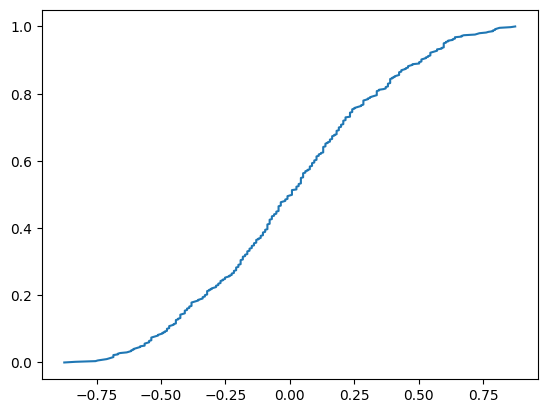

In [32]:
from matplotlib import pyplot as plt
x = np.linspace(0,1,len(null_dist))
plt.plot(null_dist,x)

----------------------------

In [53]:
from multiprocessing import Pool
connection_x_behavior2 = list(product(list(behavioral_arrays.keys())[:5], list(fMRI_arrays.keys())))
for idx, iteration in enumerate(connection_x_behavior2[19508:20333]):
    print(f"Iteration {idx} of {len(connection_x_behavior2)}")
    start_time = time.time()

    behavior = iteration[0]
    connection = iteration[1]

    behavioral_data = behavioral_arrays[behavior]

    # Format data
    pairwise_arrays = np.vstack((behavioral_data, fMRI_arrays[connection])).transpose() ###enlever age, sex, movement pour moi
    #print(pairwise_arrays)
    pairwise_dataframe = pd.DataFrame(data=pairwise_arrays, columns=['behavior', 'fMRI'], dtype='float32')###enlever age, sex, movement pour moi

    pairwise_dataframe = pairwise_dataframe.dropna().reset_index(drop=True)  # account for subjects with missing  ###usefull for me? 
    if not ('TR-' in connection):  # if movie-wide analysis, use absolute values for all covariates/behavior  
        pairwise_dataframe.loc[:, pairwise_dataframe.columns != 'fMRI'] = \
            np.absolute(pairwise_dataframe.loc[:, pairwise_dataframe.columns != 'fMRI'])  # all columns that aren't fMRI ###only behavior for me since I don't have 
    # Statistical test
    correlation = pg.corr(x=pairwise_dataframe['fMRI'], y=pairwise_dataframe['behavior'], method='spearman') ###gives n, ouliers, r, CI95, p-val, BF10, power

    # Null distribution
    """threads = 7
    with Pool(threads) as pool:
        n = pool.amap(null_dist, [pairwise_dataframe] * threads)
    pool.join()
    pool.close()
    null_distribution=n.get()"""
    """with Pool (processes=7) as pool: #processes = number of thread (coeur) I use on my computer
        null_distribution = pool.map(null_dist, pairwise_dataframe)
    pool.close()"""
    #null_distribution = np.block(null_distribution)
    null_distribution = null_dist(pairwise_dataframe)
    # Test Fisher transformed correlations. Absolute null z less then absolute observed z
    greater_less_sum = np.sum(np.absolute(np.arctanh(null_distribution)) <= np.absolute(np.arctanh(correlation.r[0])))  ###compte le nombre de fois que 
    ###la valeur que l'on veut tester est plus petite que la valeur significative
    permutation_significance = 1.0 - (greater_less_sum / num_perms)
    #permutation_significance = np.nan ###initialise à np.nan si la ligne précédente ne compte aucun résultat significatif (donc somme =0)

    statistical_tests.loc[len(statistical_tests)+1] = [behavior, connection, correlation.r[0], correlation['p-val'][0],
                                  permutation_significance]

    #print("--- %s seconds ---" % (time.time() - start_time))
statistical_tests

Iteration 0 of 48770
Iteration 1 of 48770
Iteration 2 of 48770
Iteration 3 of 48770
Iteration 4 of 48770
Iteration 5 of 48770
Iteration 6 of 48770
Iteration 7 of 48770
Iteration 8 of 48770
Iteration 9 of 48770
Iteration 10 of 48770
Iteration 11 of 48770
Iteration 12 of 48770
Iteration 13 of 48770
Iteration 14 of 48770
Iteration 15 of 48770
Iteration 16 of 48770
Iteration 17 of 48770
Iteration 18 of 48770
Iteration 19 of 48770
Iteration 20 of 48770
Iteration 21 of 48770
Iteration 22 of 48770
Iteration 23 of 48770
Iteration 24 of 48770
Iteration 25 of 48770
Iteration 26 of 48770
Iteration 27 of 48770
Iteration 28 of 48770
Iteration 29 of 48770
Iteration 30 of 48770
Iteration 31 of 48770
Iteration 32 of 48770


KeyboardInterrupt: 

In [34]:
ref = ['7Networks_LH_SalVentAttn_Med_1', '7Networks_RH_SalVentAttn_Med_1', '7Networks_LH_Cont_PFCl_5', '7Networks_RH_Cont_PFCl_9', '7Networks_LH_SomMot_4',
       '7Networks_RH_SomMot_6', 'Hippocampus']
fMRI_name_selected = []
for fMRI in (fMRI_arrays.keys()):
    str_fMRI = str(fMRI)
    if any(word in str_fMRI for word in ref):
        fMRI_name_selected.append(str_fMRI)


In [60]:
fMRI_name_selected[16:574]

['Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-1',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-2',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-3',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-4',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-5',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-6',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-7',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-8',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-9',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-10',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-11',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-12',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-13',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-14',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-15',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-16',
 'Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-17',
 'Left Amygdala_x_7Networks_LH_SalVentAt

In [62]:
len(list(product(list(behavioral_arrays.keys())[2:3], fMRI_name_selected))), len(list(product(list(behavioral_arrays.keys())[:5], fMRI_name_selected[16:574])))

(8944, 2790)

In [64]:
from multiprocessing import Pool
connection_x_behavior = list(product(list(behavioral_arrays.keys())[2:3], fMRI_name_selected[16:574])) #only doing it for DASS_anx and 7Networks_LH_SalVentAttn_Med_1_TRs
for idx, iteration in enumerate(connection_x_behavior):
    print(f"Iteration {idx} of {len(connection_x_behavior)}")
    start_time = time.time()

    behavior = iteration[0]
    connection = iteration[1]

    behavioral_data = behavioral_arrays[behavior]

    # Format data
    pairwise_arrays = np.vstack((behavioral_data, fMRI_arrays[connection])).transpose() ###enlever age, sex, movement pour moi
    #print(pairwise_arrays)
    pairwise_dataframe = pd.DataFrame(data=pairwise_arrays, columns=['behavior', 'fMRI'], dtype='float32')###enlever age, sex, movement pour moi

    pairwise_dataframe = pairwise_dataframe.dropna().reset_index(drop=True)  # account for subjects with missing  ###usefull for me? 
    if not ('TR-' in connection):  # if movie-wide analysis, use absolute values for all covariates/behavior  
        pairwise_dataframe.loc[:, pairwise_dataframe.columns != 'fMRI'] = \
            np.absolute(pairwise_dataframe.loc[:, pairwise_dataframe.columns != 'fMRI'])  # all columns that aren't fMRI ###only behavior for me since I don't have 
    # Statistical test
    correlation = pg.corr(x=pairwise_dataframe['fMRI'], y=pairwise_dataframe['behavior'], method='spearman') ###gives n, ouliers, r, CI95, p-val, BF10, power

    # Null distribution
    """threads = 7
    with Pool(threads) as pool:
        n = pool.amap(null_dist, [pairwise_dataframe] * threads)
    pool.join()
    pool.close()
    null_distribution=n.get()"""
    #print('Before pool')
    """with Pool (processes=7) as pool: #processes = number of thread (coeur) I use on my computer
        null_distribution = pool.map(null_dist, pairwise_dataframe)
    pool.close()"""
    #print('After Pool')
    #null_distribution = np.block(null_distribution)
    null_distribution = null_dist(pairwise_dataframe)
    # Test Fisher transformed correlations. Absolute null z less then absolute observed z
    greater_less_sum = np.sum(np.absolute(np.arctanh(null_distribution)) <= np.absolute(np.arctanh(correlation.r[0])))  ###compte le nombre de fois que 
    ###la valeur que l'on veut tester est plus petite que la valeur significative
    permutation_significance = 1.0 - (greater_less_sum / num_perms)
    #permutation_significance = np.nan ###initialise à np.nan si la ligne précédente ne compte aucun résultat significatif (donc somme =0)

    statistical_tests.loc[len(statistical_tests)+1] = [behavior, connection, correlation.r[0], correlation['p-val'][0],
                                  permutation_significance]

    #print("--- %s seconds ---" % (time.time() - start_time))
statistical_tests

Iteration 0 of 558
Iteration 1 of 558
Iteration 2 of 558
Iteration 3 of 558
Iteration 4 of 558
Iteration 5 of 558
Iteration 6 of 558
Iteration 7 of 558
Iteration 8 of 558
Iteration 9 of 558
Iteration 10 of 558
Iteration 11 of 558
Iteration 12 of 558
Iteration 13 of 558
Iteration 14 of 558
Iteration 15 of 558
Iteration 16 of 558
Iteration 17 of 558
Iteration 18 of 558
Iteration 19 of 558
Iteration 20 of 558
Iteration 21 of 558
Iteration 22 of 558
Iteration 23 of 558
Iteration 24 of 558
Iteration 25 of 558
Iteration 26 of 558
Iteration 27 of 558
Iteration 28 of 558
Iteration 29 of 558
Iteration 30 of 558
Iteration 31 of 558
Iteration 32 of 558
Iteration 33 of 558
Iteration 34 of 558
Iteration 35 of 558
Iteration 36 of 558
Iteration 37 of 558
Iteration 38 of 558
Iteration 39 of 558
Iteration 40 of 558
Iteration 41 of 558
Iteration 42 of 558
Iteration 43 of 558
Iteration 44 of 558
Iteration 45 of 558
Iteration 46 of 558
Iteration 47 of 558
Iteration 48 of 558
Iteration 49 of 558
Iteration 

,Behavior,Connection,r,p,perm_p
1,DASS_anx,Left Amygdala_x_7Networks_LH_Vis_1,0.434272,0.209825,0.9622
2,DASS_anx,Left Amygdala_x_7Networks_LH_Vis_2,0.660848,0.037494,0.9533
3,DASS_anx,Left Amygdala_x_7Networks_LH_Vis_3,0.560147,0.092169,0.9554
4,DASS_anx,Left Amygdala_x_7Networks_LH_Vis_4,0.484622,0.155743,0.9599
5,DASS_anx,Left Amygdala_x_7Networks_LH_Vis_5,0.195108,0.589081,0.9808
...,...,...,...,...,...
739,DASS_anx,Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1...,-0.283999,0.426480,0.9719
740,DASS_anx,Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1...,-0.364260,0.300756,0.9661
741,DASS_anx,Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1...,-0.364260,0.300756,0.9679
742,DASS_anx,Left Amygdala_x_7Networks_LH_SalVentAttn_Med_1...,-0.364260,0.300756,0.9672


In [65]:
# Save dictionary using pickle
pkl_file = open("Movie_wise_DASS_anx_AAC_L_TRs.pkl", "wb")
pickle.dump(statistical_tests, pkl_file)
pkl_file.close()
statistical_tests.to_csv('Movie_wise_DASS_anx_AAC_L_TRs.csv', index=False)

In [71]:
import json
with open('data/Annot_Sintel_stim.json', 'r') as f:
    # Lecture du contenu du fichier et chargement des données JSON en tant que dictionnaire
    annot = json.load(f)
index_anx = annot['Columns'].index('Anxiety')

In [90]:
ratings = np.genfromtxt('data/Annot_Sintel_stim.tsv', delimiter='\t')
anx_rating = ratings[:,index_anx]

In [95]:
from scipy import signal
resampling_len = len(statistical_tests["r"])
anx_rating_ressampled= signal.resample(anx_rating, resampling_len)
anx_rating_ressampled.shape


(743,)

In [99]:
x=np.array(statistical_tests["r"])
y = anx_rating_ressampled

LAmygdala_LAAC_anxiety = pg.corr(x,y, method="pearson")
LAmygdala_LAAC_anxiety

,n,r,CI95%,p-val,BF10,power
pearson,743,-0.113142,"[-0.18, -0.04]",0.00201,5.37,0.871386


In [97]:
null_distribution = null_dist_pearson(x, y, num_perms)
greater_less_sum = np.sum(np.absolute(np.arctanh(null_distribution)) <= np.absolute(np.arctanh(LAmygdala_LAAC_anxiety.r[0])))
LAmygdala_LAAC_anxiety_sig = 1.0 - (greater_less_sum / num_perms)

In [101]:
LAmygdala_LAAC_anxiety_sig, greater_less_sum, null_distribution

(0.0019000000000000128,
 9981,
 array([ 0.0250778 ,  0.01435747, -0.03562816, ...,  0.01472246,
        -0.06524027, -0.04247231]))